Author: Christian Sarmiento <br>
Instructor: Dr. Reza Sadgehi <br>
Course: Deep Learning (DATA 492L) <br>
Purpose: Sleep Pose Detection Using CNN <br>
Description: Deep Learning HW assignment #2. Make base model and then tune/experiment for better accuracy. <br>
Date: 2/8/2024

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import math
import os
import csv
import shutil
import matplotlib.pyplot as plt
from keras import layers
from tensorflow import data as tfData


In [2]:
# Load Data
!unzip -q "/content/train.zip" -d "/content/train"

In [3]:
# Read and Organize Folders by Class
for folder in (' Back', ' Fetal', ' Side', ' Stomach'):

  # Make new folder to move all of the corresponding photos in
  destinationPath = f'/content/train/train/{folder}'
  exists = os.path.exists(destinationPath) and os.path.isdir(destinationPath)
  if not exists:
    os.mkdir(destinationPath)

  # Read csv
  csvPath = '/content/_classes.csv'
  with open(csvPath, mode='r', newline='') as file:
    csvReader = csv.DictReader(file) # output row contents as a dictionary

    # Iterate over each row in the csv
    for row in csvReader:
      for columnName, columnValue in row.items():  # Each column

        if columnName != 'filename':  # Bypasses filename attribute

          # Saves given photo file path
          fileName = row['filename']
          originalPath = f"/content/train/train/{fileName}"

          if columnName == folder:  # folder we are trying add pictures to
            if columnValue == ' 1':  # if the photo belongs to this category
              try:
                shutil.move(originalPath, destinationPath)
                print(f"File moved successfully to {destinationPath}")
              except Exception as e:
                print(f"Error moving file: {e}")

File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /content/train/train/ Back
File moved successfully to /

In [4]:
# Generate Dataset
photosTrain, photosVal = tf.keras.utils.image_dataset_from_directory(
    "/content/train/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(200,200),
    batch_size=100,
)

Found 411 files belonging to 4 classes.
Using 329 files for training.
Using 82 files for validation.


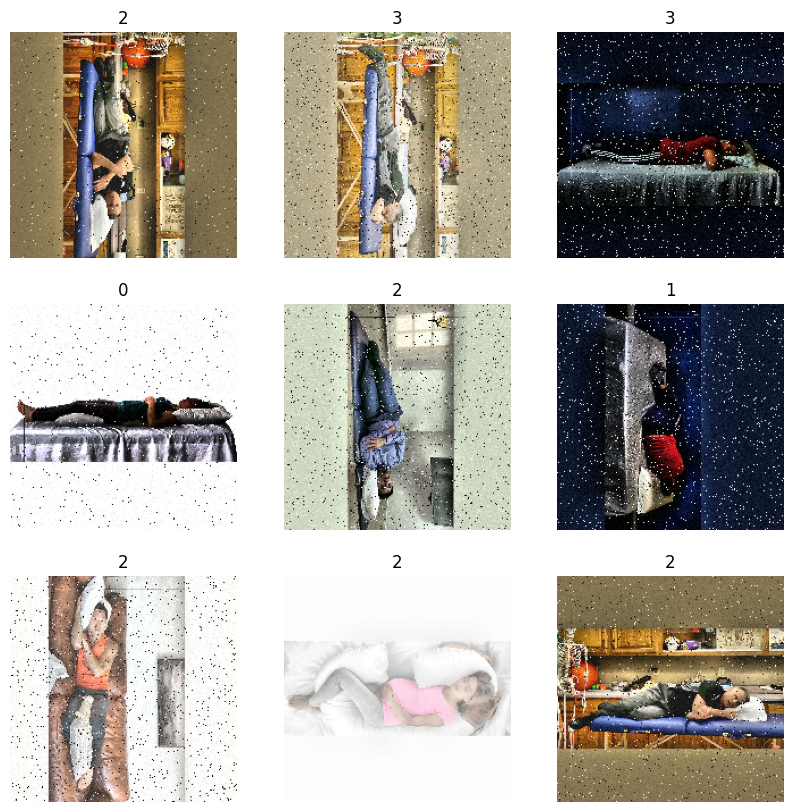

In [ ]:
# Plot
plt.figure(figsize=(10, 10))
for images, labels in photosTrain.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
# Data Augmentation
dataAugmentationLayers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def dataAugmentation(images):
    for layer in dataAugmentationLayers:
        images = layer(images)
    return images

# Apply data augmentation to the training images.
photosTrain = photosTrain.map(
    lambda img, label: (dataAugmentation(img), label),
    num_parallel_calls=tfData.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
photosTrain = photosTrain.prefetch(tfData.AUTOTUNE)
photosVal = photosVal.prefetch(tfData.AUTOTUNE)

In [ ]:
# Original Model

# Define Model
originalModel = tf.keras.Sequential(
    [
        # Input Entry Block
        tf.keras.Input(shape=(200, 200, 3)),  # 200px x 200px, RGB (3 colors)
        tf.keras.layers.Rescaling(1.0/255),
        tf.keras.layers.Conv2D(kernel_size=4, filters=12, use_bias=False, padding='same'),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        # Hidden Layers
        tf.keras.layers.Conv2D(kernel_size=8, filters=24, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(kernel_size=8, filters=32, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compile Model
originalModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss='sparse_categorical_crossentropy',  # used when categories are integers
              metrics=['accuracy'])

# Print model layers
originalModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      576       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 12)      36        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 200, 200, 12)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 24)      18432     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 24)      72        
 chNormalization)                                       

In [ ]:
# Train & Fit CNN
epochs = 30
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
history = originalModel.fit(
    photosTrain,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=photosVal,
)

Epoch 1/30
4/4 [==============================] - 49s 10s/step - loss: 2.5797 - accuracy: 0.3009 - val_loss: 6121.8223 - val_accuracy: 0.2683
Epoch 2/30
4/4 [==============================] - 40s 9s/step - loss: 1.8966 - accuracy: 0.2888 - val_loss: 1131.1947 - val_accuracy: 0.3171
Epoch 3/30
4/4 [==============================] - 37s 8s/step - loss: 1.5387 - accuracy: 0.3891 - val_loss: 1034.1686 - val_accuracy: 0.2683
Epoch 4/30
4/4 [==============================] - 37s 8s/step - loss: 1.7231 - accuracy: 0.3465 - val_loss: 344.1099 - val_accuracy: 0.2683
Epoch 5/30
4/4 [==============================] - 37s 8s/step - loss: 1.4677 - accuracy: 0.3891 - val_loss: 274.1792 - val_accuracy: 0.2927
Epoch 6/30
4/4 [==============================] - 36s 8s/step - loss: 1.4164 - accuracy: 0.4012 - val_loss: 267.7332 - val_accuracy: 0.2805
Epoch 7/30
4/4 [==============================] - 37s 8s/step - loss: 1.3749 - accuracy: 0.4377 - val_loss: 201.8706 - val_accuracy: 0.2805
Epoch 8/30
4/4 [

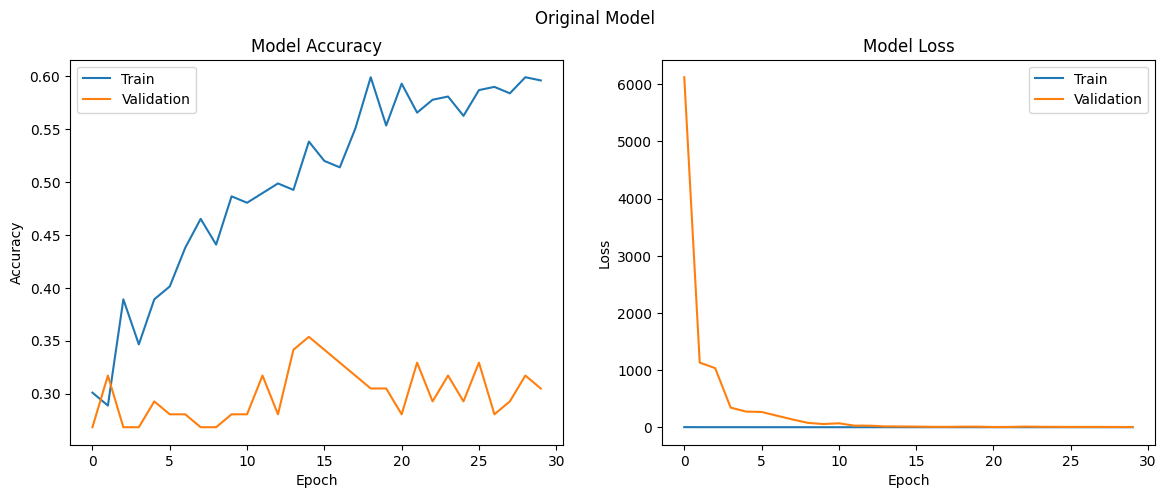

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.suptitle('Original Model')

plt.show()

In [ ]:
# Optimized Model

# Define Model
optimizedModel = tf.keras.Sequential(
    [
        # Input Entry Block
        tf.keras.Input(shape=(200, 200, 3)),  # 200px x 200px, RGB (3 colors)
        tf.keras.layers.Rescaling(1.0/255),
        tf.keras.layers.Conv2D(kernel_size=5, filters=12, use_bias=False, padding='same'),  # kernel size changed to 5 here, 10 in subsequent layers
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        # Hidden Layers
        tf.keras.layers.Conv2D(kernel_size=10, filters=24, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(kernel_size=10, filters=32, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compile Model
optimizedModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss='sparse_categorical_crossentropy',  # used when categories are integers
              metrics=['accuracy'])

# Print model layers
optimizedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      900       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 12)      36        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 200, 200, 12)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 24)      28800     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 24)      72        
 chNormalization)                                       

<ipython-input-10-33dc11706ada>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx = np.arange(epochs+1, dtype=np.float)


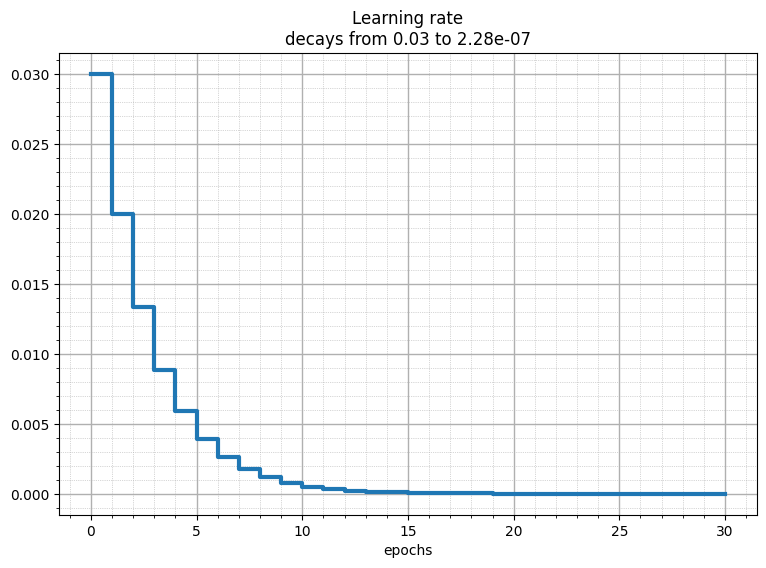

In [10]:
# Adding learning rate decay

# Both functions from keras_05_mnist_batch_norm notebook

def lrDecay(epoch):
  return 0.03 * math.pow(0.666, epoch)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lrDecay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  plt.show()

# Learning rate decay callback
lrDecayCallback = tf.keras.callbacks.LearningRateScheduler(lrDecay, verbose=True)

# important to see what you are doing
epochs = 30
plot_learning_rate(lrDecay, epochs)

In [ ]:
# Train & Fit CNN
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"), lrDecayCallback]
historyOptimized = optimizedModel.fit(
    photosTrain,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=photosVal,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.03.
Epoch 1/30
4/4 [==============================] - 57s 13s/step - loss: 2.9638 - accuracy: 0.2128 - val_loss: 3707.1074 - val_accuracy: 0.2683 - lr: 0.0300

Epoch 2: LearningRateScheduler setting learning rate to 0.01998.
Epoch 2/30
4/4 [==============================] - 56s 13s/step - loss: 1.9042 - accuracy: 0.3769 - val_loss: 1014.8913 - val_accuracy: 0.1707 - lr: 0.0200

Epoch 3: LearningRateScheduler setting learning rate to 0.013306680000000001.
Epoch 3/30
4/4 [==============================] - 55s 13s/step - loss: 1.4810 - accuracy: 0.3708 - val_loss: 156.4916 - val_accuracy: 0.1951 - lr: 0.0133

Epoch 4: LearningRateScheduler setting learning rate to 0.008862248880000001.
Epoch 4/30
4/4 [==============================] - 56s 13s/step - loss: 1.4690 - accuracy: 0.3951 - val_loss: 119.7911 - val_accuracy: 0.2683 - lr: 0.0089

Epoch 5: LearningRateScheduler setting learning rate to 0.005902257754080002.
Epoch 5/30
4/4 [

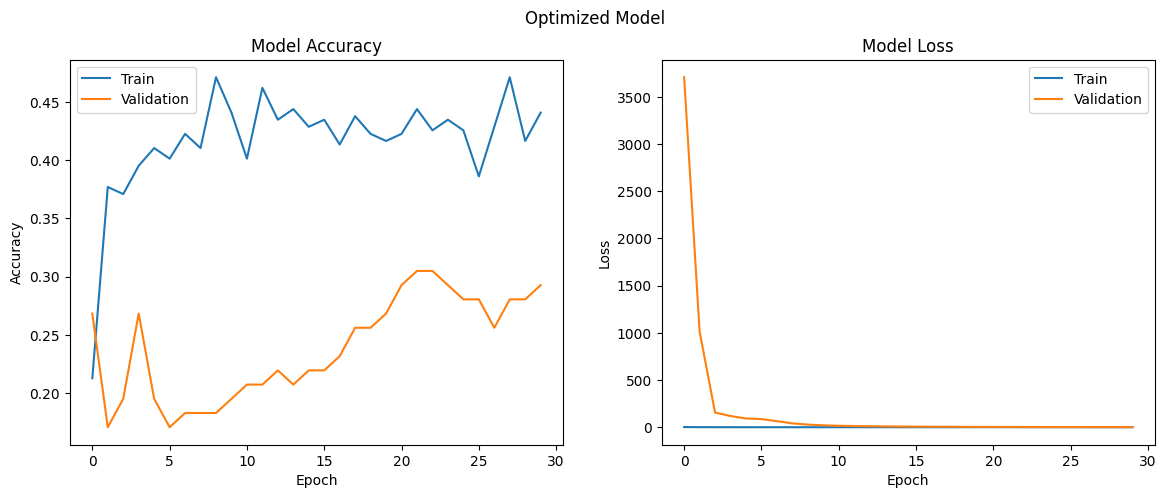

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(historyOptimized.history['accuracy'])
plt.plot(historyOptimized.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyOptimized.history['loss'])
plt.plot(historyOptimized.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.suptitle('Optimized Model')

plt.show()

Increasing the kernel to 5 didn't really do anything. Adding the learning rate decay thoroughly heavily decreased our accuracy in both training and validation, although brought the margin between train and validation accuracy together more. Let's lower the learning rate to 1% to see if it does anything

In [ ]:
# Optimized Model

# Define Model
optimizedModel2 = tf.keras.Sequential(
    [
        # Input Entry Block
        tf.keras.Input(shape=(200, 200, 3)),  # 200px x 200px, RGB (3 colors)
        tf.keras.layers.Rescaling(1.0/255),
        tf.keras.layers.Conv2D(kernel_size=5, filters=12, use_bias=False, padding='same'),  # kernel size changed to 5 here, 10 in subsequent layers
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        # Hidden Layers
        tf.keras.layers.Conv2D(kernel_size=10, filters=24, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(kernel_size=10, filters=32, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compile Model
optimizedModel2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',  # used when categories are integers
              metrics=['accuracy'])

# Print model layers
optimizedModel2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 12)      900       
                                                                 
 batch_normalization_8 (Bat  (None, 200, 200, 12)      36        
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 200, 200, 12)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 24)      28800     
                                                                 
 batch_normalization_9 (Bat  (None, 100, 100, 24)      72        
 chNormalization)                                     

<ipython-input-7-61d4198a16cb>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx = np.arange(epochs+1, dtype=np.float)


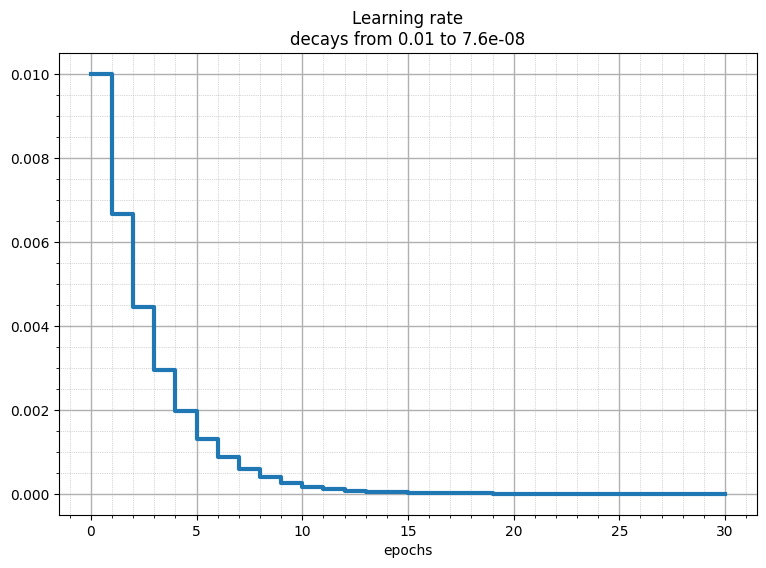

In [ ]:
# Learning rate decay function
def lrDecay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# Learning rate decay callback
lrDecayCallback = tf.keras.callbacks.LearningRateScheduler(lrDecay, verbose=True)

# important to see what you are doing
epochs = 30
plot_learning_rate(lrDecay, epochs)

In [ ]:
# Train & Fit CNN
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"), lrDecayCallback]
historyOptimized2 = optimizedModel2.fit(
    photosTrain,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=photosVal,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/30
4/4 [==============================] - 65s 15s/step - loss: 2.9140 - accuracy: 0.2644 - val_loss: 1411.2885 - val_accuracy: 0.2073 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.00666.
Epoch 2/30
4/4 [==============================] - 56s 12s/step - loss: 1.8506 - accuracy: 0.3404 - val_loss: 437.3747 - val_accuracy: 0.2561 - lr: 0.0067

Epoch 3: LearningRateScheduler setting learning rate to 0.004435560000000001.
Epoch 3/30
4/4 [==============================] - 54s 12s/step - loss: 1.4978 - accuracy: 0.3526 - val_loss: 144.2723 - val_accuracy: 0.2805 - lr: 0.0044

Epoch 4: LearningRateScheduler setting learning rate to 0.0029540829600000007.
Epoch 4/30
4/4 [==============================] - 56s 13s/step - loss: 1.4178 - accuracy: 0.3769 - val_loss: 56.9828 - val_accuracy: 0.3049 - lr: 0.0030

Epoch 5: LearningRateScheduler setting learning rate to 0.0019674192513600007.
Epoch 5/30
4/4 [

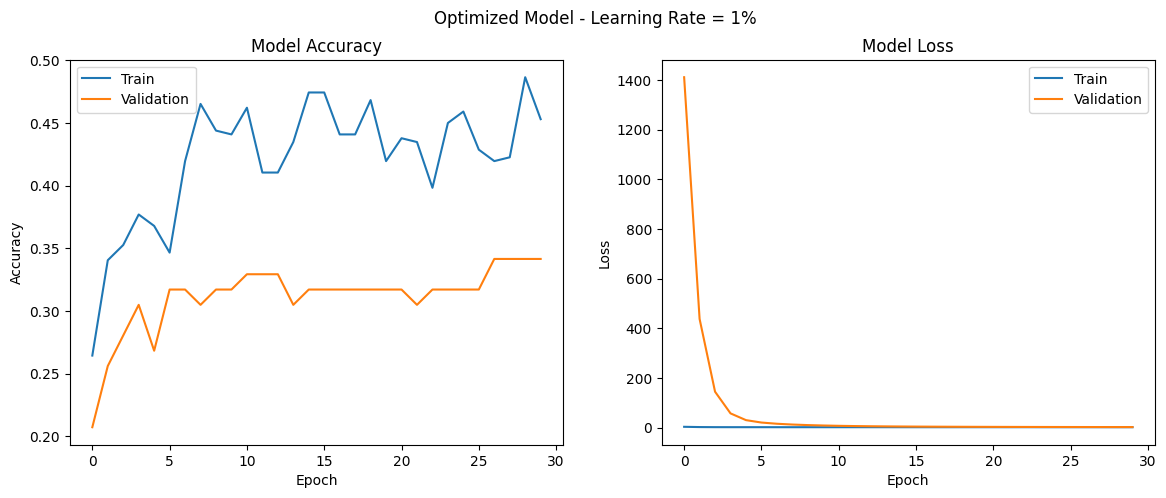

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(historyOptimized2.history['accuracy'])
plt.plot(historyOptimized2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyOptimized2.history['loss'])
plt.plot(historyOptimized2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.suptitle('Optimized Model - Learning Rate = 1%')

plt.show()

Model overall performed a bit better but there is still a discrepency between training and validation. Let's add a layer, reduce the learning rate to .001, and increase epochs by 5.

In [ ]:
# Optimized Model

# Define Model
optimizedModel3 = tf.keras.Sequential(
    [
        # Input Entry Block
        tf.keras.Input(shape=(200, 200, 3)),  # 200px x 200px, RGB (3 colors)
        tf.keras.layers.Rescaling(1.0/255),
        tf.keras.layers.Conv2D(kernel_size=5, filters=12, use_bias=False, padding='same'),  # kernel size changed to 5 here, 10 in subsequent layers
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        # Hidden Layers
        tf.keras.layers.Conv2D(kernel_size=10, filters=24, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(kernel_size=10, filters=32, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(kernel_size=10, filters=36, use_bias=False, padding='same', strides=2),  # Added an additional hidden layer, filter increased by 4
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compile Model
optimizedModel3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # used when categories are integers
              metrics=['accuracy'])

# Print model layers
optimizedModel3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 200, 12)      900       
                                                                 
 batch_normalization_12 (Ba  (None, 200, 200, 12)      36        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 200, 200, 12)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 24)      28800     
                                                                 
 batch_normalization_13 (Ba  (None, 100, 100, 24)      72        
 tchNormalization)                                    

<ipython-input-10-33dc11706ada>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx = np.arange(epochs+1, dtype=np.float)


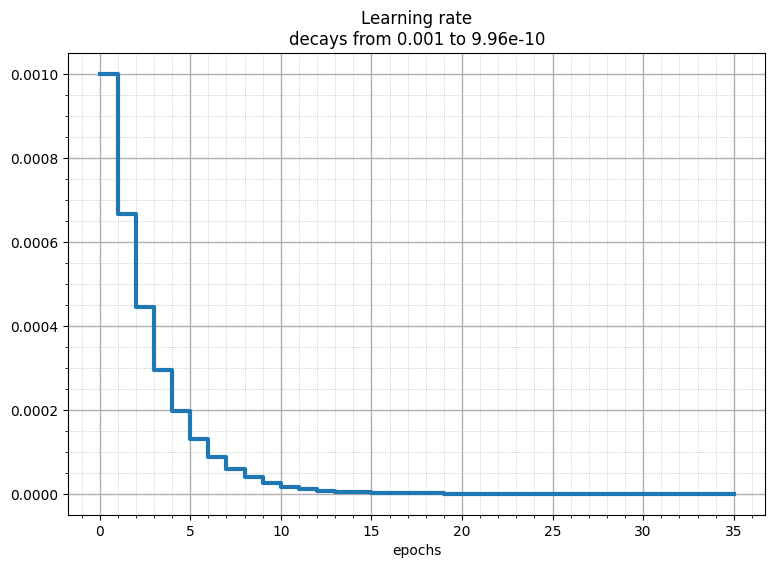

In [11]:
# Learning rate decay function
def lrDecay(epoch):
  return 0.001 * math.pow(0.666, epoch)

# Learning rate decay callback
lrDecayCallback = tf.keras.callbacks.LearningRateScheduler(lrDecay, verbose=True)

# important to see what you are doing
epochs = 35
plot_learning_rate(lrDecay, epochs)

In [ ]:
# Train & Fit CNN
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"), lrDecayCallback]
historyOptimized3 = optimizedModel3.fit(
    photosTrain,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=photosVal,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/35
4/4 [==============================] - 66s 15s/step - loss: 2.9352 - accuracy: 0.1915 - val_loss: 4.5354 - val_accuracy: 0.2927 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000666.
Epoch 2/35
4/4 [==============================] - 58s 13s/step - loss: 2.0839 - accuracy: 0.3799 - val_loss: 11.9572 - val_accuracy: 0.0244 - lr: 6.6600e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00044355600000000006.
Epoch 3/35
4/4 [==============================] - 59s 13s/step - loss: 1.7440 - accuracy: 0.3982 - val_loss: 11.0719 - val_accuracy: 0.2439 - lr: 4.4356e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00029540829600000005.
Epoch 4/35
4/4 [==============================] - 59s 13s/step - loss: 1.6292 - accuracy: 0.4225 - val_loss: 8.1866 - val_accuracy: 0.2561 - lr: 2.9541e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00019674192513600007.
Epoc

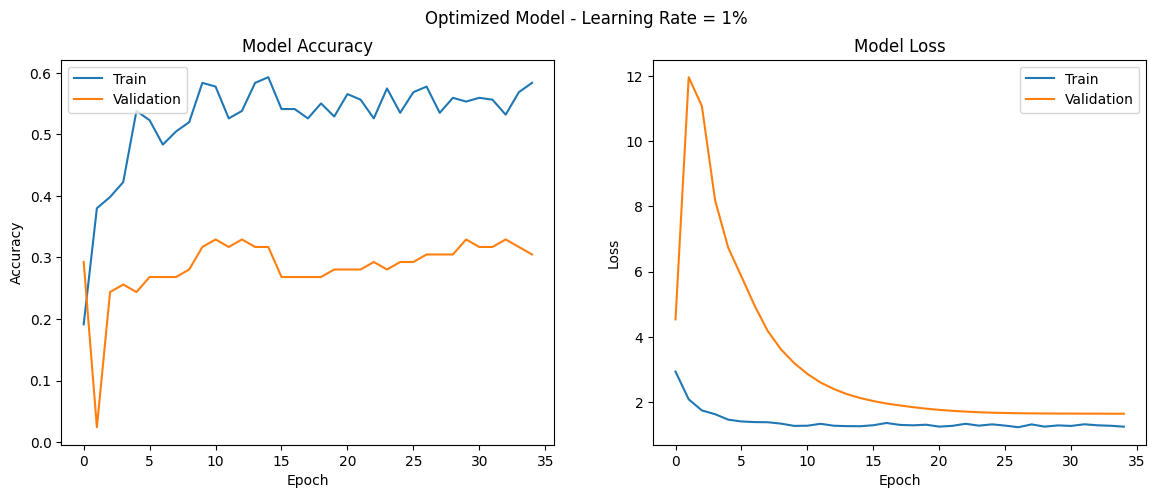

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(historyOptimized3.history['accuracy'])
plt.plot(historyOptimized3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyOptimized3.history['loss'])
plt.plot(historyOptimized3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.suptitle('Optimized Model - Learning Rate = 1%')

plt.show()

Our changes made improved our training accuracy but our validation accuracy seems to still be subpar in comparison. We should implement early stopping to see it helps us with overfitting since we can see a little bit of a bigger margin between train and validation, indicating that the model isn't generalizing well and is just remembering. We could also maybe mess around with differnt activation functions such as leaky ReLU. Quickly searching google and asking ChatGPT for some input, it might also be worth looking into adding more neurons. This is worthwhile to consider since we are flattening some pretty big input into 200 neurons. Let's see if we can implement these changes.

In [6]:
# Optimized Model

# Define Model
optimizedModel4 = tf.keras.Sequential(
    [
        # Input Entry Block
        tf.keras.Input(shape=(200, 200, 3)),  # 200px x 200px, RGB (3 colors)
        tf.keras.layers.Rescaling(1.0/255),
        tf.keras.layers.Conv2D(kernel_size=5, filters=12, use_bias=False, padding='same'),  # kernel size changed to 5 here, 10 in subsequent layers
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.LeakyReLU(),  # ReLU changed to LeakyReLU in this and subsequent layers

        # Hidden Layers
        tf.keras.layers.Conv2D(kernel_size=10, filters=24, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2D(kernel_size=10, filters=32, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2D(kernel_size=10, filters=36, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(500, use_bias=False),  # number of neurons increased from 200 to 500
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compile Model
optimizedModel4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # used when categories are integers
              metrics=['accuracy'])

# Print model layers
optimizedModel4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      900       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 12)      36        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200, 200, 12)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 24)      28800     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 24)      72        
 chNormalization)                                       

In [7]:
# Early Stopping for Overfitting
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=7,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [13]:
# Train & Fit CNN
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"), lrDecayCallback, earlyStoppingCallback]
historyOptimized4 = optimizedModel4.fit(
    photosTrain,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=photosVal,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/35
4/4 [==============================] - 61s 14s/step - loss: 6.4512 - accuracy: 0.3739 - val_loss: 38.7929 - val_accuracy: 0.2805 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000666.
Epoch 2/35
4/4 [==============================] - 61s 14s/step - loss: 2.9625 - accuracy: 0.3404 - val_loss: 19.8768 - val_accuracy: 0.1707 - lr: 6.6600e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00044355600000000006.
Epoch 3/35
4/4 [==============================] - 61s 14s/step - loss: 1.9278 - accuracy: 0.4012 - val_loss: 21.6634 - val_accuracy: 0.2805 - lr: 4.4356e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00029540829600000005.
Epoch 4/35
4/4 [==============================] - 65s 15s/step - loss: 1.7106 - accuracy: 0.4498 - val_loss: 6.3042 - val_accuracy: 0.3537 - lr: 2.9541e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00019674192513600007.
Epo

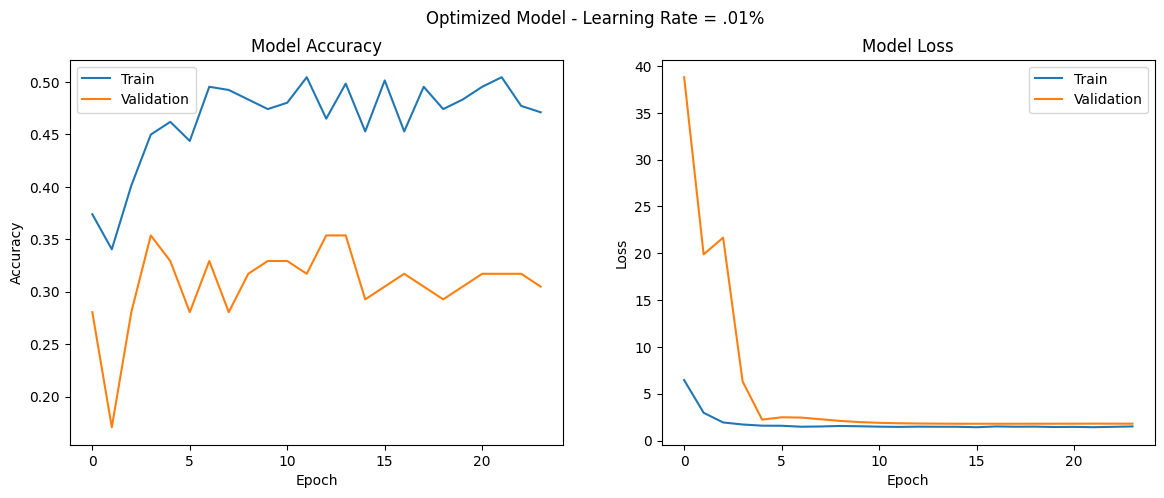

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(historyOptimized4.history['accuracy'])
plt.plot(historyOptimized4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyOptimized4.history['loss'])
plt.plot(historyOptimized4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.suptitle('Optimized Model - Learning Rate = .01%')

plt.show()

Our changes decreased our accuracy, most likely attributed to the change in neurons and activation function. Overall though, our validation accuracy is still around the same range. This being firm at around 30-35% through all these different iterations is probably due to our low sample size, having 411 classes.

In [17]:
# Optimized Model

# Define Model
optimizedModel5 = tf.keras.Sequential(
    [
        # Input Entry Block
        tf.keras.Input(shape=(200, 200, 3)),  # 200px x 200px, RGB (3 colors)
        tf.keras.layers.Rescaling(1.0/255),
        tf.keras.layers.Conv2D(kernel_size=5, filters=12, use_bias=False, padding='same'),  # kernel size changed to 5 here, 10 in subsequent layers
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),  # Changing back to ReLU with the increased neurons

        # Hidden Layers
        tf.keras.layers.Conv2D(kernel_size=10, filters=24, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(kernel_size=10, filters=32, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(kernel_size=10, filters=36, use_bias=False, padding='same', strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(500, use_bias=False),  # number of neurons increased from 200 to 500
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Compile Model
optimizedModel5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # used when categories are integers
              metrics=['accuracy'])

# Print model layers
optimizedModel5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 12)      900       
                                                                 
 batch_normalization_5 (Bat  (None, 200, 200, 12)      36        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 200, 200, 12)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 24)      28800     
                                                                 
 batch_normalization_6 (Bat  (None, 100, 100, 24)      72        
 chNormalization)                                     

In [18]:
# Train & Fit CNN
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"), lrDecayCallback, earlyStoppingCallback]
historyOptimized5 = optimizedModel5.fit(
    photosTrain,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=photosVal,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/35
4/4 [==============================] - 67s 14s/step - loss: 3.3878 - accuracy: 0.2219 - val_loss: 4.6764 - val_accuracy: 0.1707 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000666.
Epoch 2/35
4/4 [==============================] - 68s 15s/step - loss: 1.9572 - accuracy: 0.3191 - val_loss: 4.5750 - val_accuracy: 0.2317 - lr: 6.6600e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00044355600000000006.
Epoch 3/35
4/4 [==============================] - 61s 14s/step - loss: 1.5550 - accuracy: 0.4043 - val_loss: 3.1437 - val_accuracy: 0.2683 - lr: 4.4356e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00029540829600000005.
Epoch 4/35
4/4 [==============================] - 60s 14s/step - loss: 1.4513 - accuracy: 0.4012 - val_loss: 2.4391 - val_accuracy: 0.2195 - lr: 2.9541e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00019674192513600007.
Epoch 

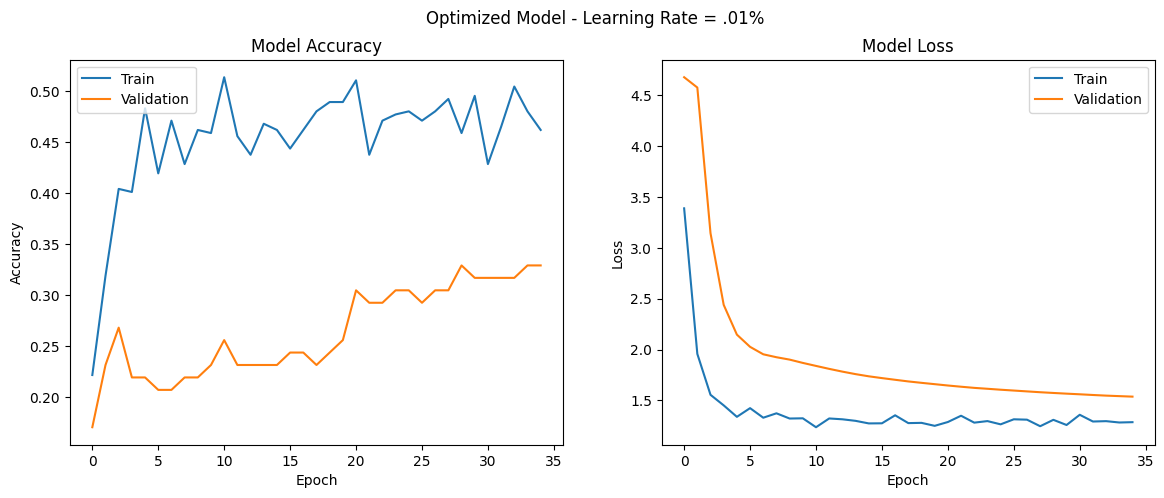

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(historyOptimized5.history['accuracy'])
plt.plot(historyOptimized5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyOptimized5.history['loss'])
plt.plot(historyOptimized5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.suptitle('Optimized Model - Learning Rate = .01%')

plt.show()

LeakyReLU is a better option to pursue.